### **Import Packages**

In [ ]:
import os
from huggingface_hub import login
login(os.environ.get('HF_TOKEN'))

In [ ]:
import os
import sys
import shutil
import json
import re
import unicodedata
import base64
import warnings
import uuid
from pathlib import Path
from typing import Dict, List, Optional, Union
from io import BytesIO
from PIL import Image
import torch
import fitz  # PyMuPDF
import pandas as pd
import mammoth
import pyarabic.araby as araby
import nest_asyncio
from bs4 import BeautifulSoup
from transformers import MllamaForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from byaldi import RAGMultiModalModel
from llama_parse import LlamaParse
from dirhash import dirhash
from llama_index.llms.openai import OpenAI
from llama_index.llms.together import TogetherLLM
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings  # For global settings
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, PromptTemplate
from llama_index.readers.file import PDFReader, PyMuPDFReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding  # pip install llama-index-embeddings-huggingface, llama-index-embeddings-instructor
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.core import StorageContext, load_index_from_storage, ServiceContext
from llama_index.core import VectorStoreIndex, get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor, LLMRerank
from llama_index.core.readers.base import BaseReader
from llama_index.core.schema import Document
from together import Together

# Custom Parsers
sys.path.append('./HyperGPT/Product/logic/custom_parsers')
from MammothDocxReader import MammothDocxReader
from MarkdownifyHTMLReader import MarkdownifyHTMLReader



OPENAI_API_KEY= os.environ["OPENAI_API_KEY"] 
TOGETHER_API_KEY=os.environ["TOGETHER_API_KEY"] 
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

# Apply nest_asyncio
nest_asyncio.apply()
import warnings
warnings.filterwarnings('ignore')

### Old version of PDF_to_text

In [3]:
# Usual Arabic OCR errors that need correction
usual_errors = {
    'اال': 'الا',
    'لال': 'للا'
}

# Function to normalize Arabic text
def normalize_arabic_text(text):
    text = re.sub(r"\u0654\u064a|\u064a\u0654", '\u0626', text)  # Normalize ئ
    text = re.sub(r"\u0654\u0648|\u0648\u0654", '\u0624', text)  # Normalize ؤ
    text = araby.strip_tashkeel(text)
    text = araby.strip_diacritics(text)
    text = araby.strip_tatweel(text)
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r"[\u0623\u0625\u0622]", '\u0627', text)  # Normalize Alef
    text = re.sub(r"\u06be", '\u0647', text)  # Normalize Heh
    for error, correction in usual_errors.items():
        text = re.sub(error, correction, text)
    return text

# Function to extract and normalize text from a specific page of a PDF
def PDFToText_apply(filepath, page):
    try:
        # Open the PDF file using PyMuPDF (fitz)
        doc = fitz.open(filepath)
        
        # Extract text from the specified page
        pdf_parsed_text = doc.load_page(page - 1).get_text("text")
        
        # Close the document
        doc.close()

        # Normalize and process the text
        pdf_parsed_text = unicodedata.normalize('NFKC', pdf_parsed_text)
        pdf_parsed_text = re.sub(r'\s+([\u064b-\u0652])', r'\1', pdf_parsed_text)
        pdf_parsed_text = normalize_arabic_text(pdf_parsed_text)
        stripped_lines = [l.strip() for l in pdf_parsed_text.split('\n')]
        pdf_parsed_text = '\n\n'.join(stripped_lines)
        pdf_parsed_text = re.sub(r'[\u202a\u202b\u202c]', r' ', pdf_parsed_text)
        pdf_parsed_text = re.sub(r'\s{4,}', r'\n\n', pdf_parsed_text)
        return pdf_parsed_text

    except Exception as e:
        print(f"Error processing page {page} of {filepath}: {e}")
        return ""

# Class to read PDF files and convert them into Document objects
class PDFToTextReader(BaseReader):
    """Read PDF files using PyMuPDF and process the text with normalization."""

    def load_data(
        self,
        file_path: Union[Path, str],
        metadata: bool = True,
        extra_info: Optional[Dict] = None,
    ) -> List[Document]:
        """Loads list of documents from a PDF file and accepts extra information."""
        return self.load(file_path, metadata=metadata, extra_info=extra_info)

    def load(
        self,
        file_path: Union[Path, str],
        metadata: bool = True,
        extra_info: Optional[Dict] = None,
    ) -> List[Document]:
        """Loads list of documents from a PDF file and accepts extra information.

        Args:
            file_path (Union[Path, str]): file path of the PDF file (accepts string or Path).
            metadata (bool, optional): if metadata is to be included or not. Defaults to True.
            extra_info (Optional[Dict], optional): extra information related to each document in dict format. Defaults to None.

        Raises:
            TypeError: if extra_info is not a dictionary.
            TypeError: if file_path is not a string or Path.

        Returns:
            List[Document]: list of documents.
        """
        # Ensure the file path is of the correct type
        if not isinstance(file_path, (str, Path)):
            raise TypeError("file_path must be a string or a Path object.")
        
        # Convert file_path to string if it's a Path object
        file_path = str(file_path)
        
        # Get the number of pages in the PDF file
        reader = fitz.open(file_path)
        num_pages = len(reader)

        # Validate and process extra_info if provided
        if extra_info and not isinstance(extra_info, dict):
            raise TypeError("extra_info must be a dictionary.")
        
        if metadata:
            if not extra_info:
                extra_info = {}
            extra_info["total_pages"] = num_pages
            extra_info["file_path"] = file_path

        # Generate a list of Document objects for each page in the PDF
        documents = []
        for i in range(num_pages):
            page_text = PDFToText_apply(file_path, i + 1)
            if page_text.strip():  # Ensure non-empty content
                document = Document(
                    text=page_text,
                    extra_info=dict(extra_info or {}, **{"source": f"Page {i+1}"})
                )
                documents.append(document)

        return documents


---

## **Integration**

In [4]:
api_key = os.environ.get("TOGETHER_API_KEY")

In [5]:
class HyperLingo:
    def __init__(
        self,
        input_folder="./output",
        retrieve_image=True,
        embeddings="E5",
        load_index=True,
        reparse=True,
        api_key=None,
        index_name="database",
    ):
        self.input_folder = input_folder
        self.api_key = api_key
        self.retrieve_image = retrieve_image
        self.index_name = index_name  # Store index_name as an instance variable

        if self.retrieve_image:
            self.initialize_image_index(index_name=self.index_name, docs_path=input_folder)

        # Embedder initialization
        if embeddings == "OpenAI":
            self.embedder = OpenAIEmbedding(model="text-embedding-3-small")
            Settings.embed_model = self.embedder
        elif embeddings == "Gemini":
            self.embedder = GeminiEmbedding(model_name="models/text-embedding-004")
            Settings.embed_model = self.embedder
        elif embeddings == "MiniLM":
            self.embedder = HuggingFaceEmbedding(
                model_name="paraphrase-multilingual-MiniLM-L12-v2"
            )
            Settings.embed_model = self.embedder
        elif embeddings == "E5":
            self.embedder = HuggingFaceEmbedding(
                model_name="intfloat/multilingual-e5-large"
            )
            Settings.embed_model = self.embedder
        elif embeddings == "BGE":
            self.embedder = HuggingFaceEmbedding(model_name="BAAI/bge-m3")
            Settings.embed_model = self.embedder

        # Reparse
        pdf_parser = PDFToTextReader()
        docx_parser = MammothDocxReader()
        html_parser = MarkdownifyHTMLReader()
        if reparse:
            self.documents = SimpleDirectoryReader(
                input_folder,
                file_extractor={
                    ".pdf": pdf_parser,
                    ".docx": docx_parser,
                    ".links": html_parser,
                },
            ).load_data()

        # If saved before then load
        expected_save_path = f"./saved_indices/{dirhash(input_folder, 'md5')}-{embeddings}"
        if os.path.exists(expected_save_path) and load_index:
            storage_context = StorageContext.from_defaults(persist_dir=expected_save_path)
            self.index = load_index_from_storage(storage_context)
        else:
            # Document reader
            if not reparse:
                self.documents = SimpleDirectoryReader(
                    input_folder,
                    file_extractor={
                        ".pdf": pdf_parser,
                        ".docx": docx_parser,
                        ".links": html_parser,
                    },
                ).load_data()

            # Sentence Splitter
            sentence_splitter = SentenceSplitter(chunk_size=1024, chunk_overlap=100)

            # Pipeline
            transforms = (sentence_splitter, self.embedder)

            # Indexer
            self.index = VectorStoreIndex.from_documents(
                self.documents, transformations=transforms
            )

            # Save index
            if not os.path.exists(f"./saved_indices"):
                os.makedirs(f"./saved_indices")

            self.index.storage_context.persist(persist_dir=expected_save_path)

    def retrieve_text_context(self, query, docs_path="docs/", k=3):
        """
        Retrieves context text based on a query.

        Args:
        - query (str): The query to search for.
        - docs_path (str): The path where the documents are stored.
        - k (int): The number of results to return (default is 3).

        Returns:
        - str: A string containing the combined text of the retrieved documents.
        """
        # Initialize the retriever
        retriever = VectorIndexRetriever(
            index=self.index,
            similarity_top_k=k,
        )

        # Perform the retrieval based on the text query
        results = retriever.retrieve(query)

        if results:
            # Combine the results to form a context string
            context = "\n".join([result.node.text for result in results])
            return context
        else:
            print("No text context found for the query.")
            return None

    def initialize_image_index(self, index_name="database", docs_path="docs/"):
        """
        Initializes the image retrieval model and index.
        """
        # Normalize docs_path to absolute path for consistency
        normalized_docs_path = os.path.abspath(docs_path)

        # Set the index_root to include the index_name
        index_root = os.path.join(".byaldi", index_name)

        # Check if the index exists
        index_exists = os.path.exists(os.path.join(index_root, "index_config.json.gz"))

        if index_exists:
            # Load the index
            self.RAG = RAGMultiModalModel.from_index(
                index_path=index_root,
                index_root=".",  # Since index_path is full path
            )
            print(f"Loaded existing index '{index_name}'.")
        else:
            # If index doesn't exist, create a new one
            self.RAG = RAGMultiModalModel.from_pretrained(
                "vidore/colqwen2-v0.1",
                index_root=index_root,
                verbose=0,
            )
            self.RAG.index(
                input_path=docs_path,
                index_name=index_name,  # Ensure index_name is passed here
                overwrite=True,
                store_collection_with_index=True,
            )
            print(f"Created new index '{index_name}' from documents in '{docs_path}'.")

    def retrieve_image_from_query(self, query, k=3):
        """
        Retrieves images based on a text query using the initialized RAG model.
        """
        if not self.retrieve_image:
            print("Image retrieval is disabled.")
            return None

        # Use the already-initialized self.RAG model
        results = self.RAG.search(query, k=k, return_base64_results=True)

        if results:
            # Collect base64 encoded images from all results
            image_base64_list = [result.base64 for result in results if result.base64]
            return image_base64_list
        else:
            print("No results found for the query.")
            return None

    def clear_image_index(self, index_name="database"):
        """
        Clears the image retrieval index by deleting the index files and resetting the RAG model.

        Args:
        - index_name (str): The name of the index to clear (default is 'database').
        """
        # Path to the index directory
        index_dir = os.path.join(".byaldi", index_name)

        # Check if the index directory exists
        if os.path.exists(index_dir):
            try:
                # Delete the index directory and its contents
                shutil.rmtree(index_dir)
                print(f"Index '{index_name}' has been cleared.")
            except Exception as e:
                print(f"Failed to clear index '{index_name}': {e}")
        else:
            print(f"No index named '{index_name}' exists.")

        # Reset the RAG model
        self.RAG = None

    def query(
        self,
        text,
        image_base64=None,
        model="Llama",
        language="Arabic",
        top_k=3,
        max_tokens=300,
        context=None,
    ):
        """
        This method sends a query to the model, including optional text and image context.

        Args:
        - text (str): The query to send to the model.
        - image_base64 (str): Base64-encoded image to provide visual context.
        - model (str): The model to use (default is 'Llama').
        - language (str): Language of the response (default is 'Arabic').
        - top_k (int): The number of results to retrieve for similarity search.
        - max_tokens (int): The maximum number of tokens for the model response.
        - context (str): Optional text-based context to be passed with the query.

        Returns:
        - str: The generated response from the model.
        """
        # Initialize the API client
        client = Together(api_key=self.api_key)

        # Model selection
        if model == "Llama":
            selected_model = "meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo"
        elif model == "GPT":
            selected_model = "gpt-3.5-turbo-instruct"
        elif model == "Gemini":
            selected_model = "models/gemini-1.5-pro"
        else:
            raise ValueError("Invalid model")

        # Construct the message payload
        message_content = [{"type": "text", "text": text}]  # Add the text query

        # Add the image if provided
        if image_base64:
            message_content.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_base64}",
                    },
                }
            )

        # Include text context if provided
        if context:
            message_content.append({"type": "text", "text": context})

        # Add the constraint to follow both text and image context
        if image_base64 or context:
            message_content.append(
                {
                    "type": "text",
                    "text": f"""Use the provided text context and image strictly to answer to the query. Do not use any external information.
                       Modify typos and Organize the answer. Be precise and concise. Your response should be in {language}.""",
                }
            )

        # Create response
        response = client.chat.completions.create(
            model=selected_model,
            messages=[
                {
                    "role": "user",
                    "content": message_content,
                }
            ],
            max_tokens=max_tokens,
        )

        # Return the model's response
        return response.choices[0].message.content

    def get_parsed_text(self, filepath):
        if not self.documents:
            raise ValueError(
                "Documents not loaded yet, please call load_data before calling get_parsed_text"
            )
        # Get all documents where metadata['file_path'] == filepath
        docs = [
            doc for doc in self.documents if doc.metadata["file_path"] == filepath
        ]
        # Merge the .text fields of the documents
        docs_text = "\n\n\n".join(
            [f"###Page {i+1}###\n\n\n{doc.text}" for i, doc in enumerate(docs)]
        )
        return docs_text


In [6]:
# Define your Arabic query
ar_query = "ماذا تعرف عن مجموعة تداول السعودية؟"

# Initialize the HyperLingo class with a custom index_name
hyper_lingo = HyperLingo(
    input_folder="/kaggle/input/data-files",
    retrieve_image=True,
    api_key=api_key,
)

# Retrieve an image based on the query
image_base64_list = hyper_lingo.retrieve_image_from_query(query=ar_query)

# Retrieve text context based on the query
context_text = hyper_lingo.retrieve_text_context(query=ar_query)

# Perform a query with both text and the retrieved image, or text-based context if available
if image_base64_list or context_text:
    # Safely get the first image if available
    image_base64 = image_base64_list[0] if image_base64_list and image_base64_list[0] else None

    # Generate a response using the model
    response = hyper_lingo.query(
        text=ar_query,
        image_base64=image_base64,  # Use image if available
        context=context_text if context_text else None,  # Use text context if available
        model="Llama",
        language="Arabic"
    )
    print("Model's response:", response)
else:
    print("No image or text context found for the query.")


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using in-memory collection. This means every image is stored in memory.
You might want to rethink this if you have a large collection!
Loaded 39 images from 1 JSON files.
Loaded existing index 'database'.


Keyword argument `padding` is not a valid argument for this processor and will be ignored.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Model's response: **مجموعة تداول السعودية**

تقدم النتائج المالية السنوية للعام 2021م، وتحقق ارتفاعًا في صافي الربح بلغ 587.70 مليون ريال سعودي.

**نبذة عن مجموعة تداول السعودية القابضة**

مجموعة تداول السعودية القابضة هي الشركة الرائدة في مجال الأسواق المالية في منطقة الشرق الأوسط وشمال أفريقيا. تضم 4 شركات تابعة، وهي:

*   شركة تداول السعودية
*   شركة مركز إيداع الأوراق المالية (ايداع)
*   شركة مركز مقاصة الأوراق المالية (المقاصة)
*   شركة تداول للحلول المبتكرة (وامض)

**النتائج المالية**

*   ارتفعت الإيرادات التشغيلية بنسبة 8.01% على أساس سنوي لتصل إلى 1,166.08 مليون ريال سعودي في العام 2021م، مقارنة مع 1,079.64 مليون ريال سعودي في العام 2020م.
*   ارتفع إجمالي الربح للمجموعة بنسبة 8.79% على أساس سنوي ليصل إلى 820.69 مليون ريال سعودي في العام 2021م، مقارنة مع 754.40 مليون ريال


In [7]:
context_text

'بيان ارباح\n\nالنتائج ا\n\nمل الية السنوية2021م\n\n6\n\nمارس2022م\n\n5\n\nنبذة عن مجموعة تداول السعودية القابضة\n\nمجموعة تداول السعودية القابضة ، املجموعة الرائدة في مجال الاسواق امللاية في منطقة الشرق الاوسط وشمال افريقيا، هي شركة\n\nقابضة تضم في محفظتها4\n\n:شركات مملوكة لها بالكامل\n\nشركة تداول السعودية ،ى حد ا\n\nاكبر الاسواق امللاية في العالم من حيث القيمة\n\nالسوقية، وشركة مركز ايداع الاوراق امللاية (ايداع )، وشركة مركز مقاصة الاوراق امللاية (املقاصة) وشركة تداول للحلول املتقدمة\n\n(وامض)\n\n، املتخصصة في توفير الحلول التقنية املبتكرة. كما تمتلك مجموعة تداول السعودية حصة قدرها33,12\n\n%\n\nمن راس مال شركة\n\nتداول العقارية التي تعمل في مجال ادارة وتطوير العقارات. تاسست املج موعة كشركة مساهمة سعودية مقفلة براس مال قدره\n\n1,200,000,000\n\nلاير سعودي مقسمة الى120,000,000\n\nسهم متساوية القيمة، وتبلغ قيمتها الاسمية10\n\n.ريالات سعودية لكل سهم\n\nتتبنى املجموعة نموذج اعمال متنوع ومكمل لبعضه باعتباره يغطي جميع الخدمات ذات العالقة، مما يسمح لها\n\nبتقديم مجموعة كاملة\n\nمن املنتجات 

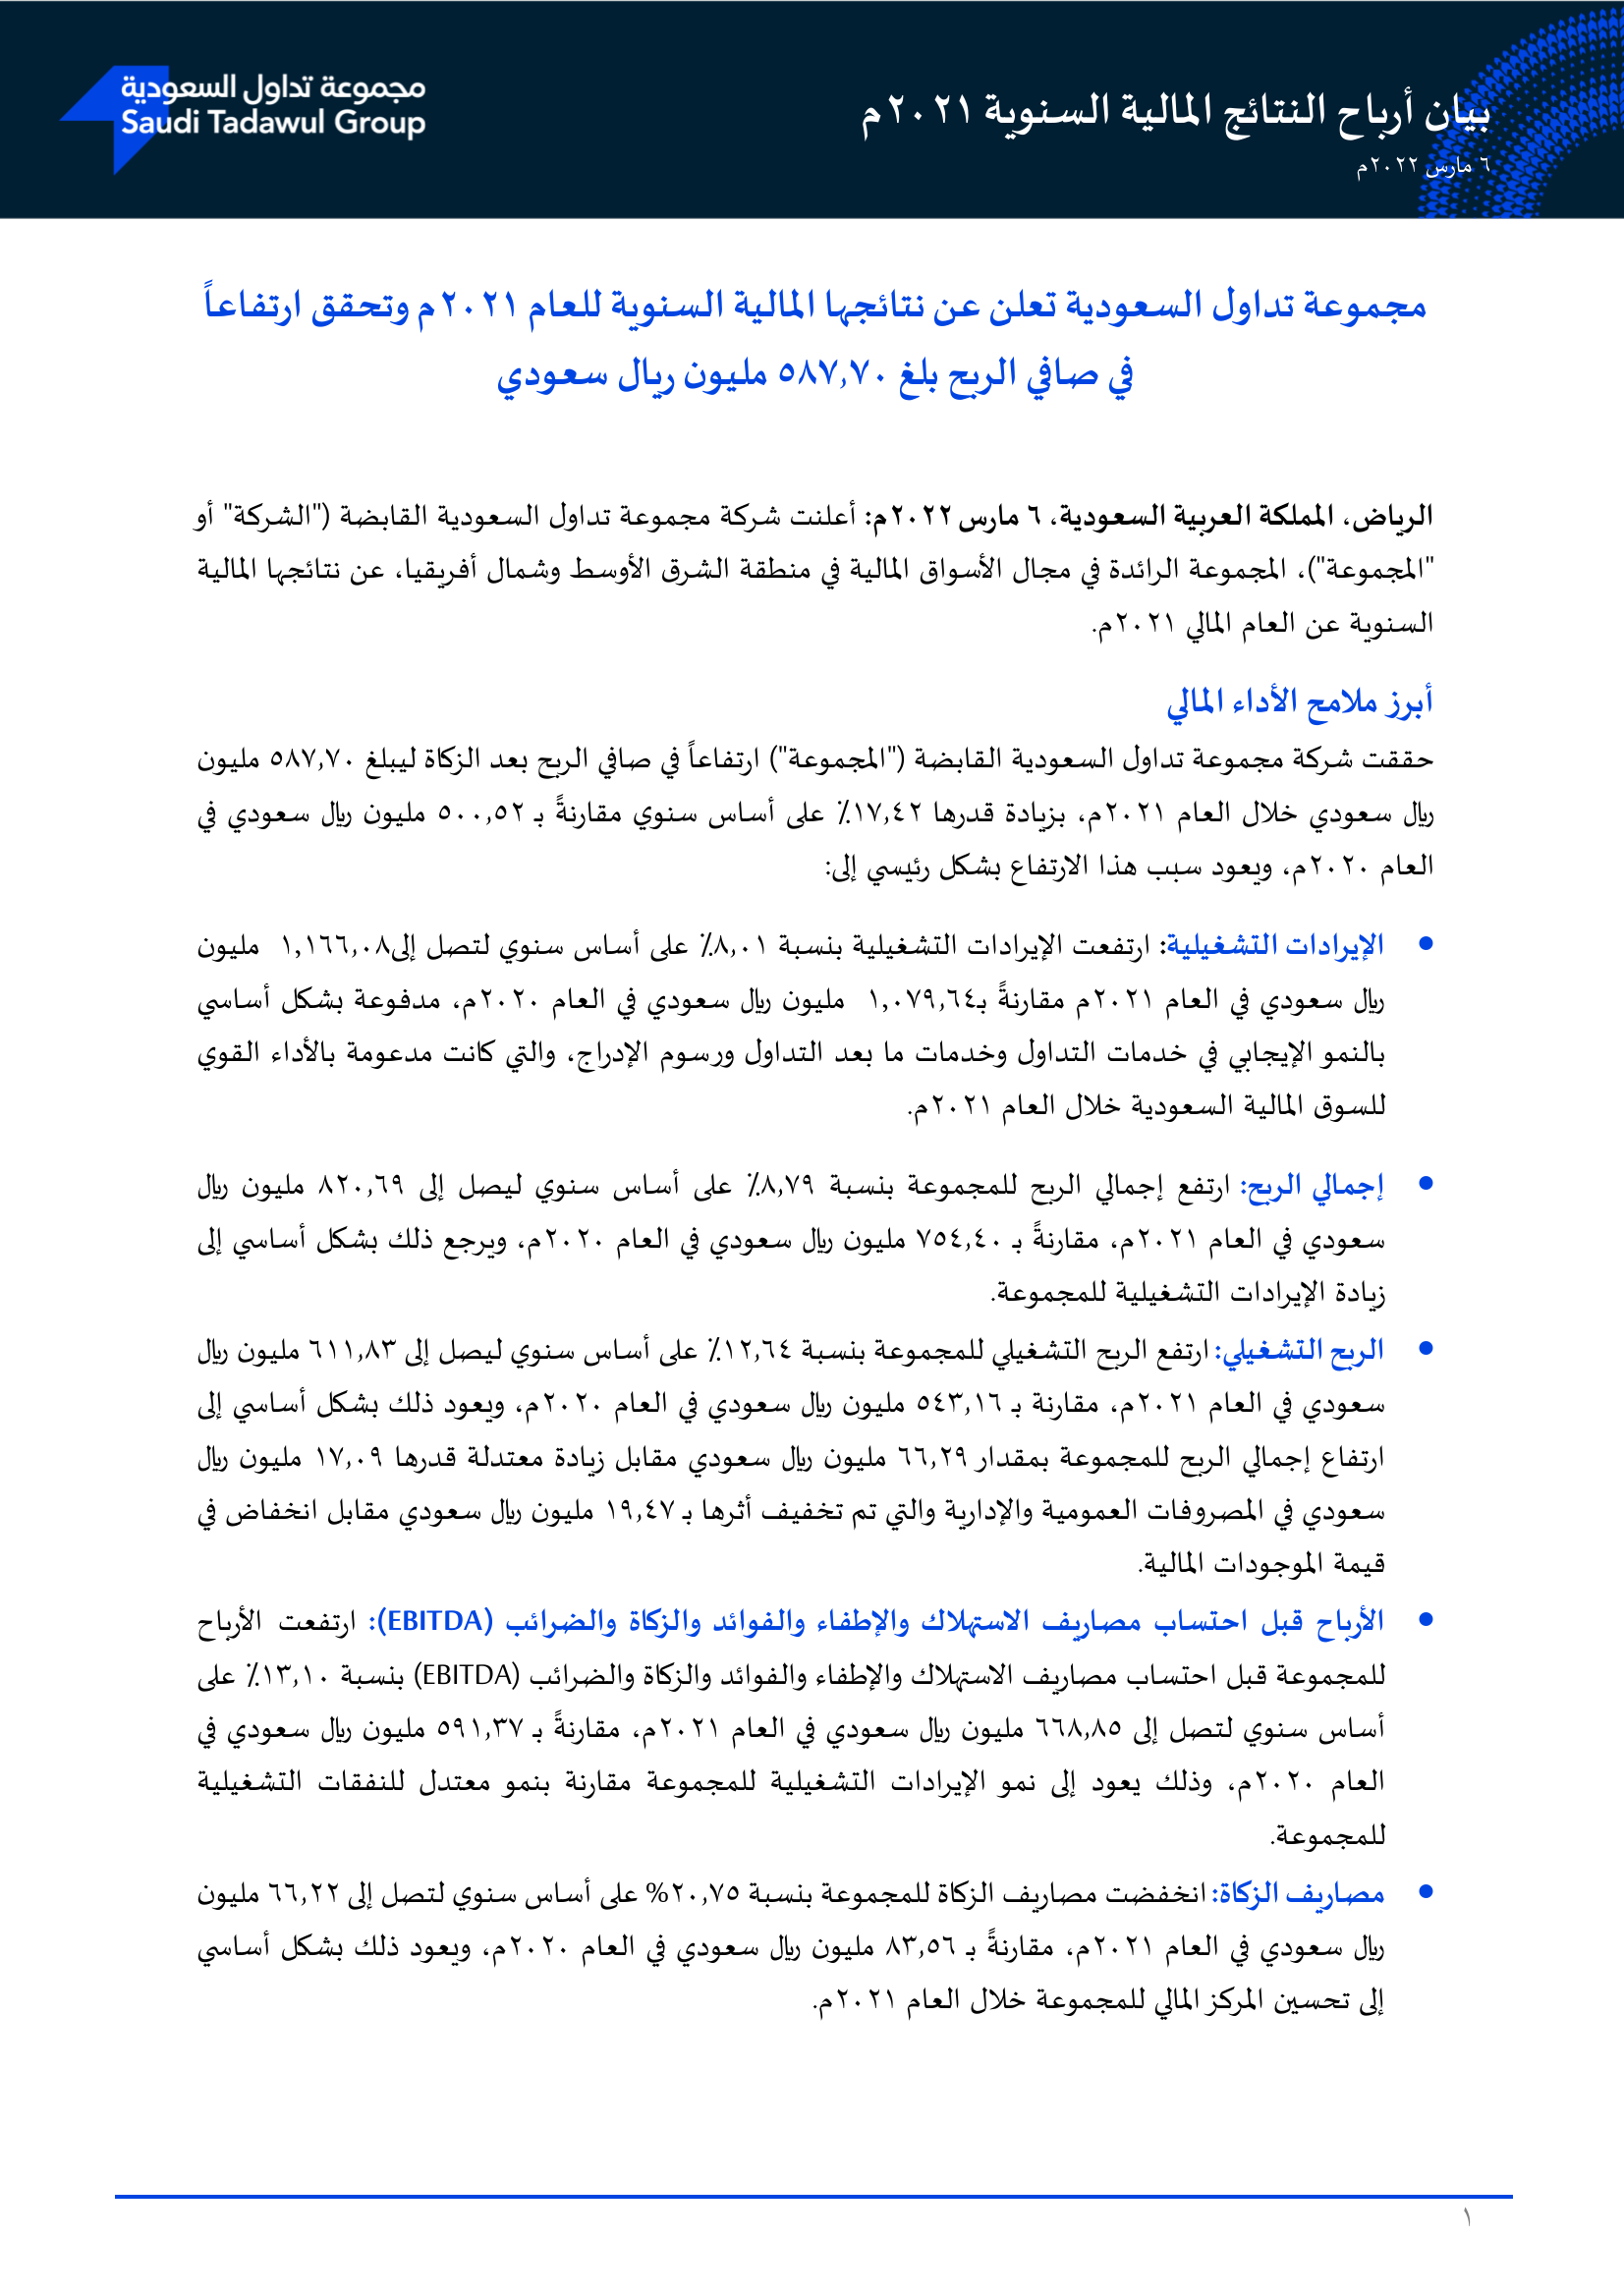

In [8]:
image = Image.open(BytesIO(base64.b64decode(image_base64_list[0])))
image

In [9]:
ar_query = "حدثني عن الباراسيتامول؟"

# Initialize the HyperLingo class with the desired index_name
hyper_lingo = HyperLingo(
    input_folder="/kaggle/input/data-files",
    retrieve_image=True,
    api_key=api_key,
    index_name="database_new"  # Specify the index_name here
)

# Retrieve an image based on the query
image_base64_list = hyper_lingo.retrieve_image_from_query(query=ar_query)

# Retrieve text context based on the query
context_text = hyper_lingo.retrieve_text_context(query=ar_query)

# Perform a query with both text and the retrieved image, or text-based context if available
if (image_base64_list and image_base64_list[0]) or context_text:
    # Safely get the first image if available
    image_base64 = image_base64_list[0] if image_base64_list else None

    response = hyper_lingo.query(
        text=ar_query,
        image_base64=image_base64,  # Use image if available
        context=context_text,       # Use text context if available
        model="Llama",
        language="Arabic"
    )
    print("Model's response:", response)
else:
    print("No image or text context found for the query.")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

overwrite is on. Deleting existing index database_new to build a new one.
Indexing file: /kaggle/input/data-files/Elect_3.pdf
Indexing file: /kaggle/input/data-files/Example.pdf
Indexing file: /kaggle/input/data-files/2408.07425v1.pdf
Indexing file: /kaggle/input/data-files/Sport_3.pdf
Indexing file: /kaggle/input/data-files/Econ_1.pdf
Created new index 'database_new' from documents in '/kaggle/input/data-files'.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Model's response: الباراسيتامول هو مسكن وخافض للحرارة واسع الاستخدام. ويصنف ضمن مسكنات اللام من النوع2. ويؤثر على نفس المستقبلات المورفينية مثل المورفين.

هو منافس على المستقبلات المورفينية مثل المورفين، وهو مسكن وخافض للحرارة واسع الاستخدام، اكتشف لأول مرة في سنة 1878 بواسطة هارمون نورثروب مورس، ويصنف ضمن مسكنات اللام من النوع 2، ويؤثر على نفس المستقبلات المورفينية مثل المورفين، وهو منافس على المستقبلات المورفينية مثل المورفين، وهو مسكن وخافض للحرارة واسع الاستخدام، اكتشف لأول مرة في سنة 1878 بواسطة هارمون نورثروب مورس، ويصنف ضمن مسكنات اللام من النوع 2، ويؤثر على نفس المستقبلات المورفينية مثل المورفين، وهو منافس على المستقبلات المورفينية مثل المورفين.

الباراسيتامول هو مسكن وخافض للحرارة واسع الاستخدام، اكتشف لأول مرة في سنة 1878 بواسطة هارمون نورثروب مورس، ويصنف ضمن مسكنات


In [10]:
context_text

'[ English text ...]\n\nLlama3 (llama_70b) Answer\n\nالباراسيتامول هو مسكن وخافض للحرارة واسع الاستخدام. ويصنف ضمن مسكنات اللام من النوع2\n\nمستقبلات نفس على ويؤثر .\n\n.المورفين، وهو منافس على المستقبلات المورفينية\n\nMixtral Answer\n\nالباراسيتامول  هو مسكن وخافض للحرارة واسع الاستخدام، اكتشف لاول مرة في سنة1878\n\n،مورسه نورتروب هارمون بواسطة\n\nالنوع من اللام مسكنات ضمن ويصنف2\n\nسنة في مرة لاول اكتشف ،الاستخدام واسع للحرارة وخافض مسكن هو الباراسيتامول1878\n\nبواسطة هارمون نورتروب مورسه، ويؤثر على نفس مستقبلا\n\nت المورفين\n\nFig. 3. Sample of ARCD Questions and Answers Generated by the used LLMs\n\n7 https://github.com/SElBeltagy/ArRagExperiments\n10\n\nAuthor name / Procedia Computer Science 00 (2024) 000–000\n\nARCD dataset, only the last three open-source LLMs were employed. Each of the open-source LLMs, generated\n\nsuperfluous text in which the answer to the query was often embedded. To apply the chosen metrics as accurately as\n\npossible, post-processing functions were writ

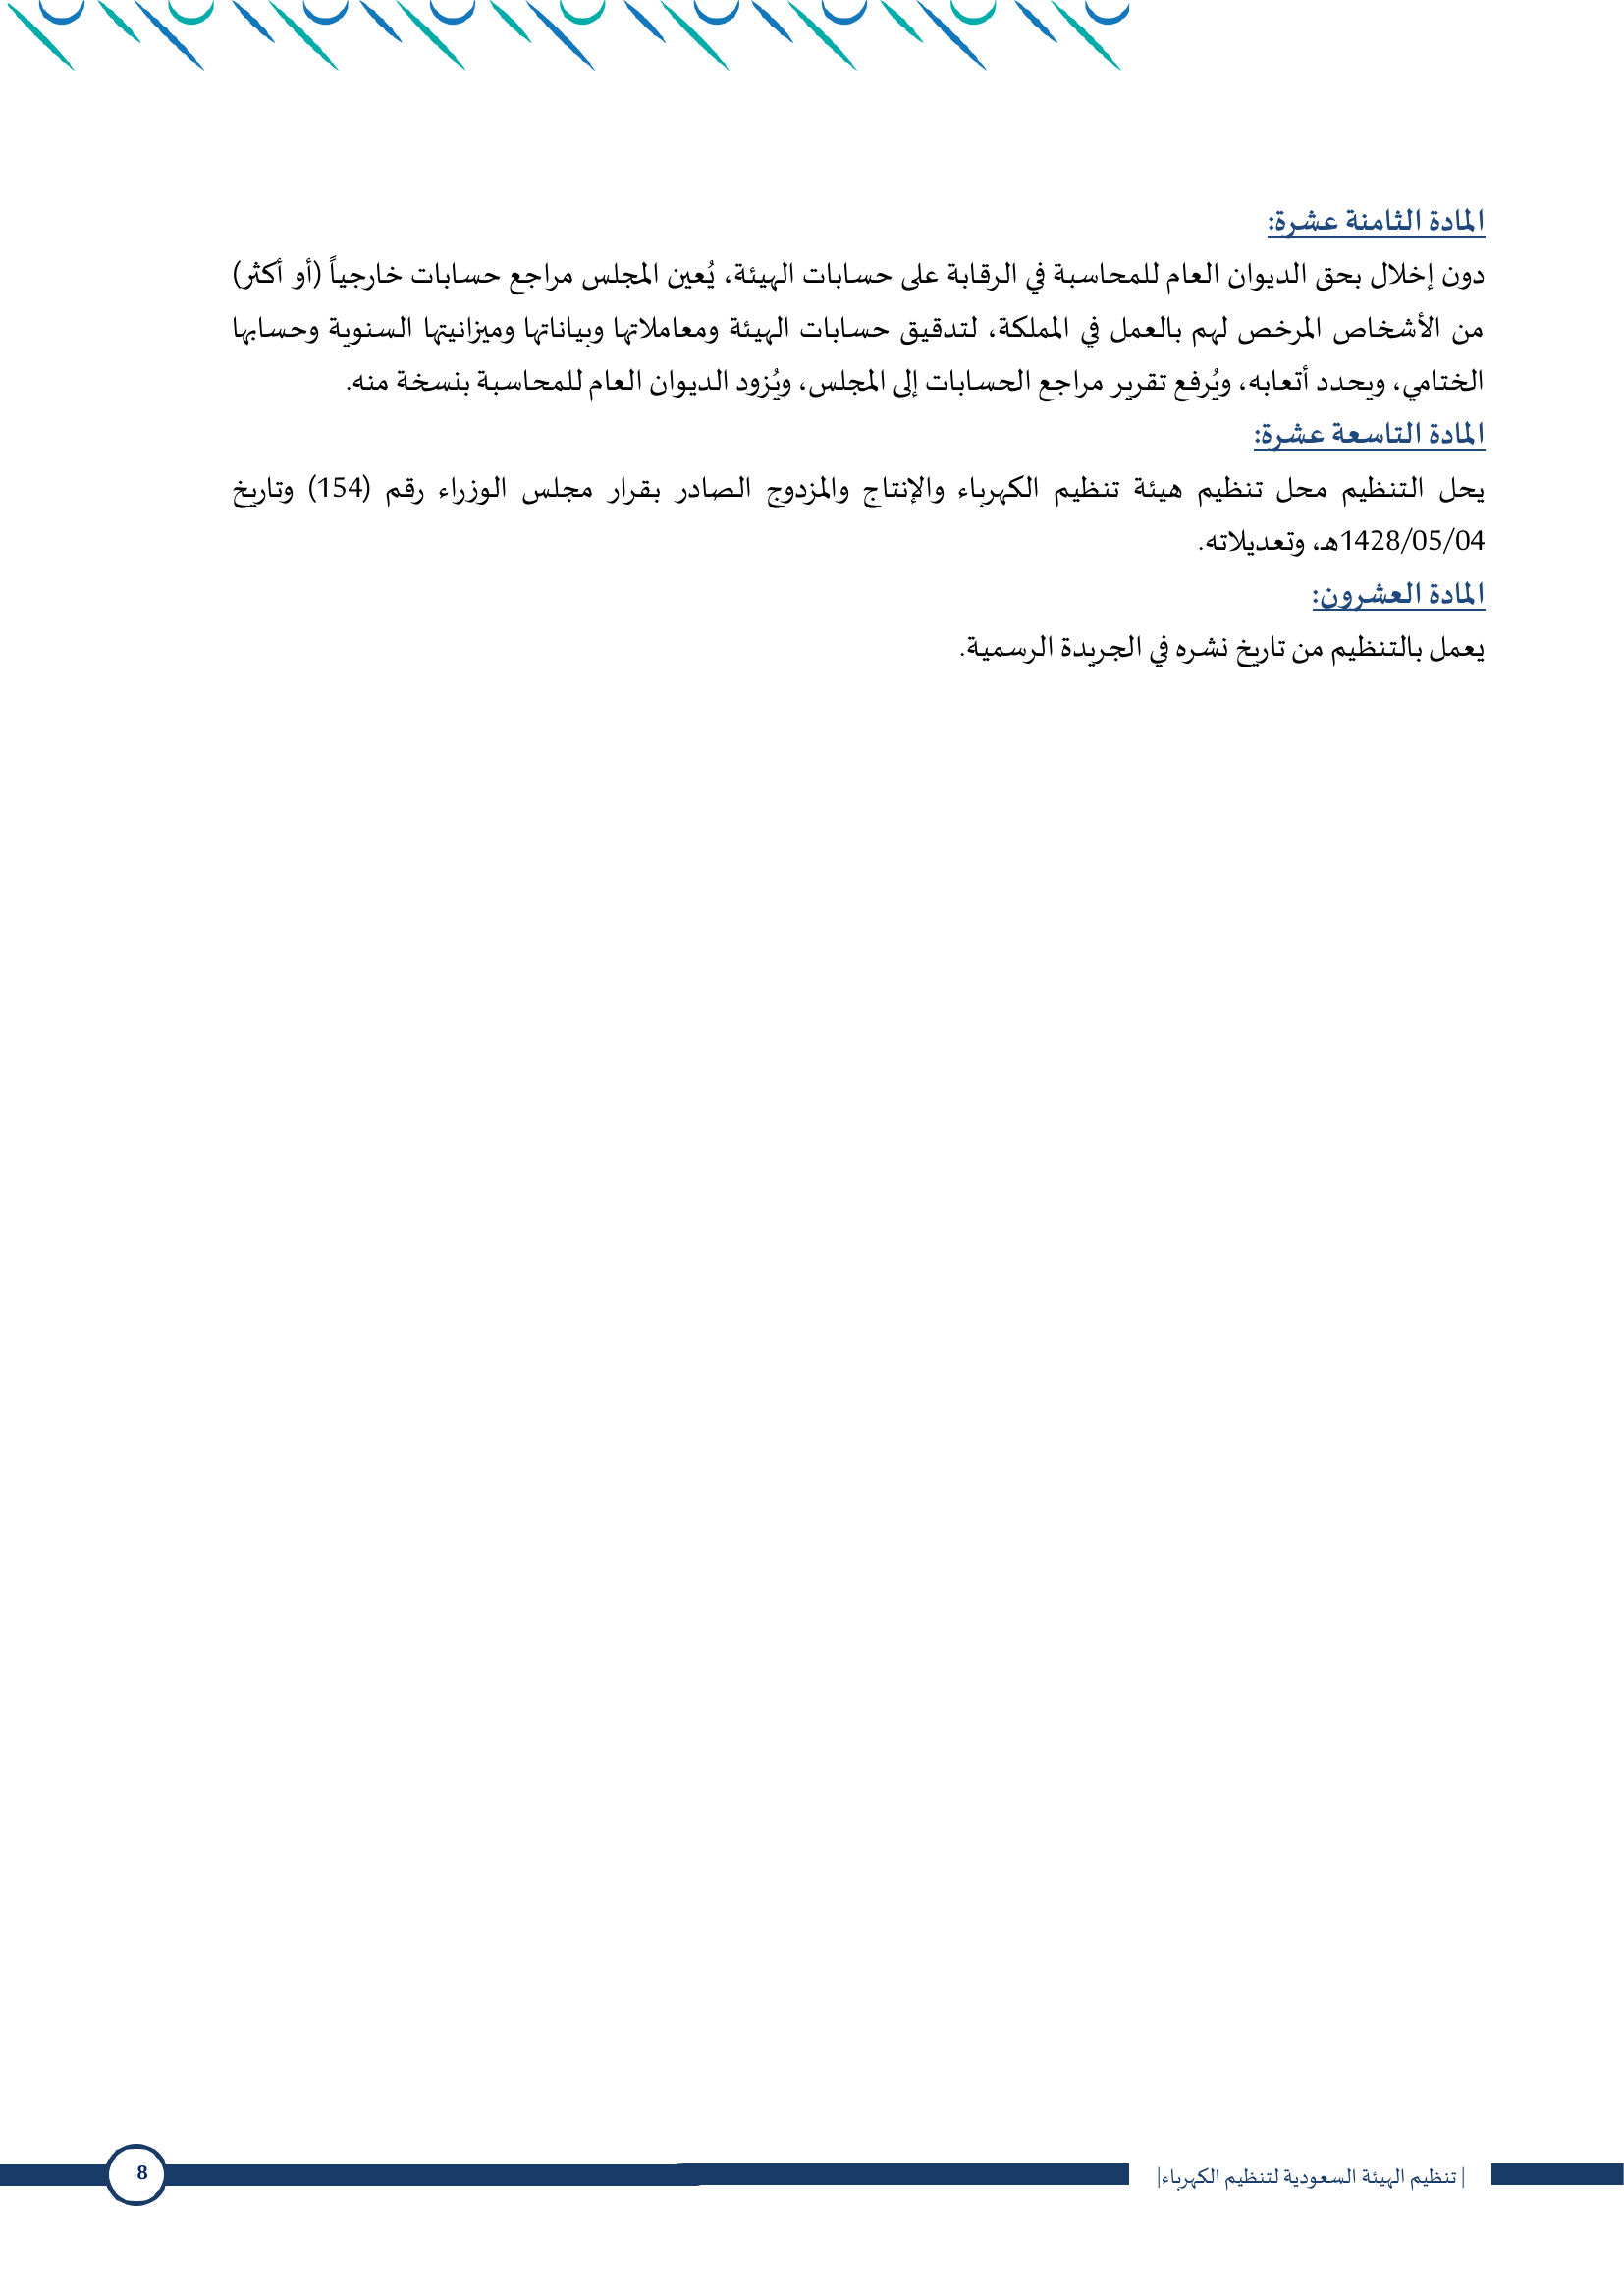

In [11]:
image = Image.open(BytesIO(base64.b64decode(image_base64_list[0])))
image

In [14]:
hyper_lingo.clear_image_index("database")

Index 'database' has been cleared.
